In [9]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import squarify
from sklearn.cluster import KMeans

def plot_answer_similarity_distribution_facet_combined(folder_path, category=None, n_clusters=3, csv_path='similarity_clusters_combined.csv'):
    

    dfs = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            df = pd.DataFrame(data)
            model_name = filename.replace('.json', '')
            if category is not None:
                df = df[df['psychiatric_category'] == category]
            # Keep only needed columns
            df = df[['Modified Questions', 'Reasonings', 'Generated Vanilla Answer', 'Generated RAG Answer', 'Top k Similarity', 'Retrieved Context',
                     'Answer Semantic Similarity for rag', 'RAG Rubric Score',
                     'Answer Semantic Similarity for vanilla', 'Vanilla Rubric Score']].copy()
            df['Model'] = model_name
            dfs.append(df)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    if not dfs:
        print("No data found.")
        return

    all_df = pd.concat(dfs, ignore_index=True)
    # Remove NaNs for both
    all_df = all_df.dropna(subset=[
        'Answer Semantic Similarity for rag', 'RAG Rubric Score',
        'Answer Semantic Similarity for vanilla', 'Vanilla Rubric Score'
    ])

    
    bins = [0, 0.2, 0.4, 0.6, 0.8, 0.85, 0.9, 0.95, 1.0]
    labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-0.85', '0.85-0.9', '0.9-0.95', '0.95-1.0']
    all_df['RAG_Similarity_bin'] = pd.cut(all_df['Answer Semantic Similarity for rag'], bins=bins, labels=labels, include_lowest=True)
    all_df['Vanilla_Similarity_bin'] = pd.cut(all_df['Answer Semantic Similarity for vanilla'], bins=bins, labels=labels, include_lowest=True)

    
    df_rag = all_df.dropna(subset=['RAG_Similarity_bin', 'RAG Rubric Score']).copy()
    df_rag['RAG_Similarity_bin_num'] = df_rag['RAG_Similarity_bin'].cat.codes
    X_rag = df_rag[['RAG_Similarity_bin_num', 'RAG Rubric Score']].astype(float)
    kmeans_rag = KMeans(n_clusters=n_clusters, random_state=42)
    rag_clusters = kmeans_rag.fit_predict(X_rag)
    all_df.loc[df_rag.index, 'RAG_Cluster'] = rag_clusters

    
    df_van = all_df.dropna(subset=['Vanilla_Similarity_bin', 'Vanilla Rubric Score']).copy()
    df_van['Vanilla_Similarity_bin_num'] = df_van['Vanilla_Similarity_bin'].cat.codes
    X_van = df_van[['Vanilla_Similarity_bin_num', 'Vanilla Rubric Score']].astype(float)
    kmeans_van = KMeans(n_clusters=n_clusters, random_state=42)
    van_clusters = kmeans_van.fit_predict(X_van)
    all_df.loc[df_van.index, 'Vanilla_Cluster'] = van_clusters

    # Save to CSV
    all_df.to_csv(csv_path, index=False)

    # RAG cluster summary and treemap
    rag_summary = df_rag.copy()
    rag_summary['Cluster'] = rag_clusters
    rag_cluster_summary = rag_summary.groupby('Cluster').agg({
        'RAG Rubric Score': ['mean', 'count'],
        'RAG_Similarity_bin': lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A'
    }).round(2)
    rag_cluster_summary.columns = ['Avg_Rubric', 'Count', 'Most_Common_Sim_Bin']
    rag_cluster_summary = rag_cluster_summary.reset_index()

    rag_labels, rag_colors = [], []
    for _, row in rag_cluster_summary.iterrows():
        cluster_id = int(row['Cluster'])
        if row['Avg_Rubric'] >= 4.0:
            performance = "High Perf"
            color = 'green'
        elif row['Avg_Rubric'] >= 3.0:
            performance = "Moderate Perf"
            color = 'orange'
        else:
            performance = "Low Perf"
            color = 'red'
        label = (
            f"Cluster {cluster_id}\n"
            f"{performance}\n"
            f"{int(row['Count'])} cases\n"
            f"Rubric: {row['Avg_Rubric']:.2f}\n"
            f"Sim: {row['Most_Common_Sim_Bin']}"
        )
        rag_labels.append(label)
        rag_colors.append(color)

    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=rag_cluster_summary['Count'], label=rag_labels, color=rag_colors, alpha=0.7, pad=True)
    plt.axis('off')
    plt.title('RAG Performance Clusters - Treemap Visualization\n(Size = Number of Cases)', fontsize=16)
    plt.show()

    # Vanilla cluster summary and treemap
    van_summary = df_van.copy()
    van_summary['Cluster'] = van_clusters
    van_cluster_summary = van_summary.groupby('Cluster').agg({
        'Vanilla Rubric Score': ['mean', 'count'],
        'Vanilla_Similarity_bin': lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A'
    }).round(2)
    van_cluster_summary.columns = ['Avg_Rubric', 'Count', 'Most_Common_Sim_Bin']
    van_cluster_summary = van_cluster_summary.reset_index()

    van_labels, van_colors = [], []
    for _, row in van_cluster_summary.iterrows():
        cluster_id = int(row['Cluster'])
        if row['Avg_Rubric'] >= 4.0:
            performance = "High Perf"
            color = 'green'
        elif row['Avg_Rubric'] >= 3.0:
            performance = "Moderate Perf"
            color = 'orange'
        else:
            performance = "Low Perf"
            color = 'red'
        label = (
            f"Cluster {cluster_id}\n"
            f"{performance}\n"
            f"{int(row['Count'])} cases\n"
            f"Rubric: {row['Avg_Rubric']:.2f}\n"
            f"Sim: {row['Most_Common_Sim_Bin']}"
        )
        van_labels.append(label)
        van_colors.append(color)

    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=van_cluster_summary['Count'], label=van_labels, color=van_colors, alpha=0.7, pad=True)
    plt.axis('off')
    plt.title('Vanilla Performance Clusters - Treemap Visualization\n(Size = Number of Cases)', fontsize=16)
    plt.show()

    return rag_cluster_summary, van_cluster_summary

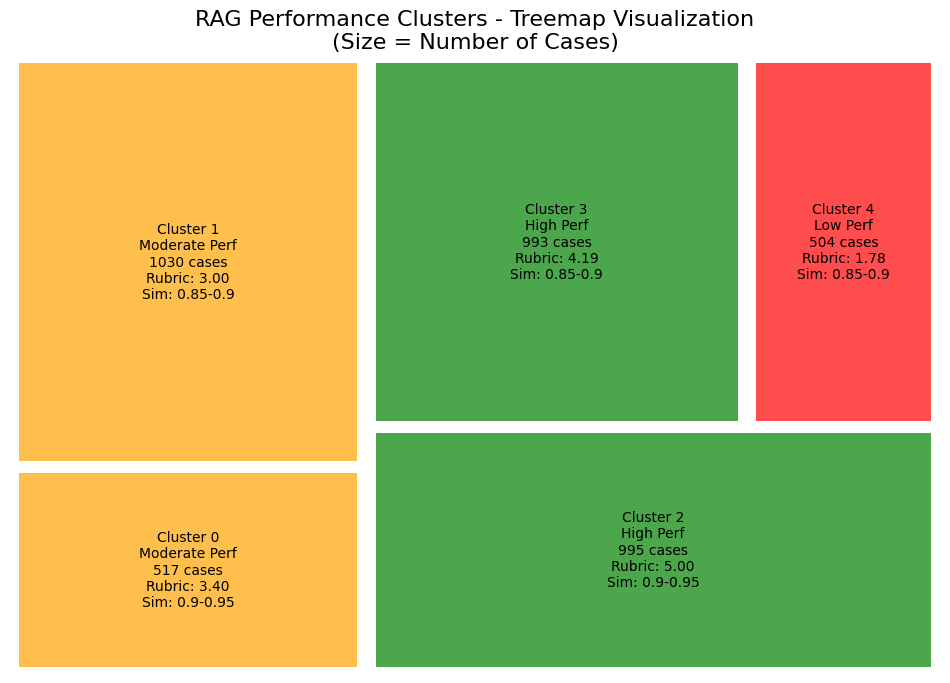

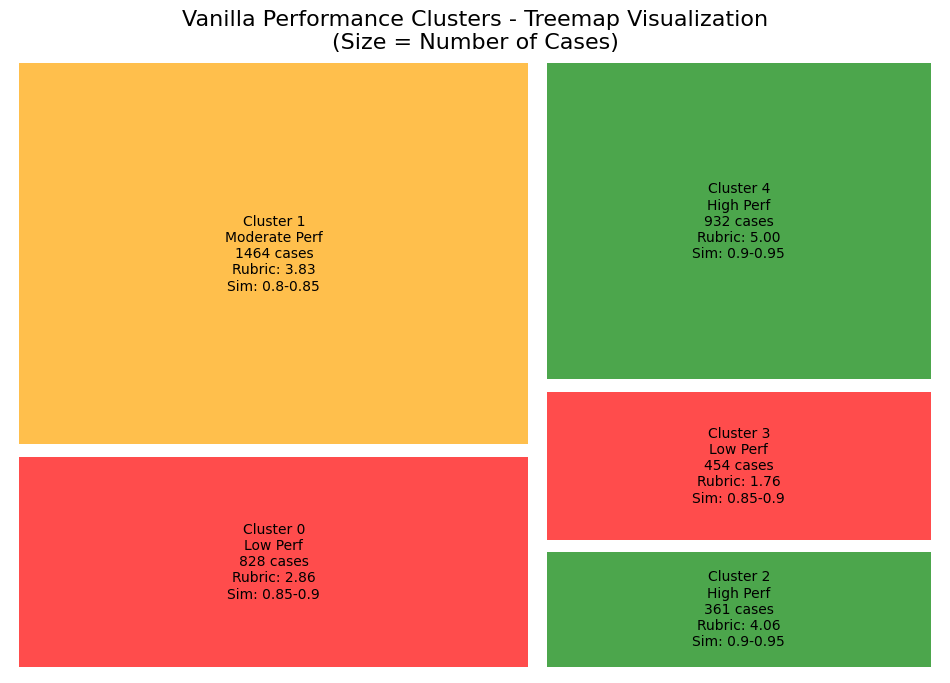

(   Cluster  Avg_Rubric  Count Most_Common_Sim_Bin
 0        0        3.40    517            0.9-0.95
 1        1        3.00   1030            0.85-0.9
 2        2        5.00    995            0.9-0.95
 3        3        4.19    993            0.85-0.9
 4        4        1.78    504            0.85-0.9,
    Cluster  Avg_Rubric  Count Most_Common_Sim_Bin
 0        0        2.86    828            0.85-0.9
 1        1        3.83   1464            0.8-0.85
 2        2        4.06    361            0.9-0.95
 3        3        1.76    454            0.85-0.9
 4        4        5.00    932            0.9-0.95)

In [10]:
plot_answer_similarity_distribution_facet_combined("advanced_rag/results", n_clusters=5, csv_path='similarity_clusters_combined.csv')

When we manually inspect the generated questions, we can find examples of questions with relatively high semantic similarity to GT answer but having low overal rubric score. In example above, we can spot the cluster
3 in vanilla results and cluster 4 in RAG results.  

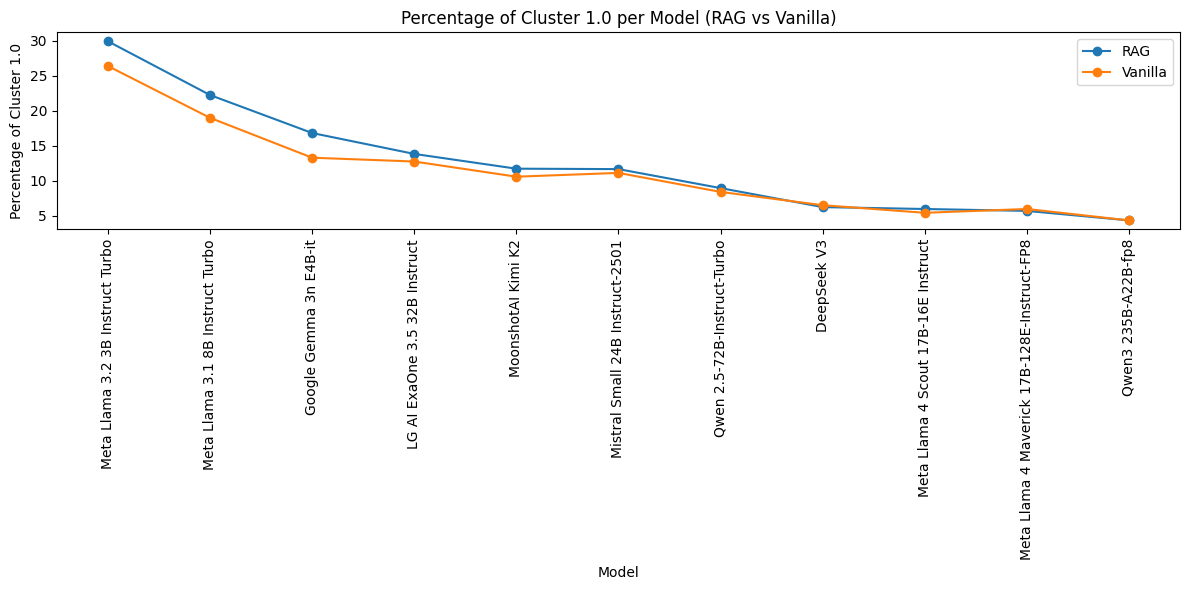

In [7]:
# Prepare a function to get cluster 1.0 percentages for a given cluster column

df = pd.read_csv("similarity_clusters_combined_cluster_0608.csv")

def get_cluster1_percent(df, cluster_col, cluster_num=1.0):
    cluster_counts = df.groupby(['Model', cluster_col]).size().reset_index(name='Count')
    total_counts = cluster_counts.groupby('Model')['Count'].transform('sum')
    cluster_counts['Percent'] = cluster_counts['Count'] / total_counts * 100
    # Only keep cluster 1.0
    cluster1 = cluster_counts[cluster_counts[cluster_col] == cluster_num][['Model', 'Percent']]
    cluster1 = cluster1.set_index('Model')
    return cluster1

# Get cluster 1.0 percentages for RAG and Vanilla
rag_1 = get_cluster1_percent(df, 'RAG_Cluster', cluster_num=4.0).rename(columns={'Percent': 'RAG'})
van_1 = get_cluster1_percent(df, 'Vanilla_Cluster', cluster_num=3.0).rename(columns={'Percent': 'Vanilla'})

# Combine into one DataFrame
combined = pd.concat([rag_1, van_1], axis=1).fillna(0)

# Optional: sort by RAG or Vanilla
combined = combined.sort_values('RAG', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(combined.index, combined['RAG'], marker='o', label='RAG')
plt.plot(combined.index, combined['Vanilla'], marker='o', label='Vanilla')
plt.ylabel('Percentage of Cluster 1.0')
plt.xlabel('Model')
plt.title('Percentage of Cluster 1.0 per Model (RAG vs Vanilla)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
def create_cluster_percentage_table(df):
    """
    Create a table showing percentage of specific clusters and remaining clusters for each model.
    
    Args:
        df: DataFrame with cluster data (should have 'Model', 'RAG_Cluster', 'Vanilla_Cluster' columns)
    
    Returns:
        DataFrame with cluster percentages by model
    """
    results = []
    
    # Get unique models
    models = df['Model'].unique()
    
    for model in models:
        model_data = df[df['Model'] == model]
        
        # RAG cluster analysis
        rag_total = model_data['RAG_Cluster'].notna().sum()
        rag_cluster_4_count = (model_data['RAG_Cluster'] == 4.0).sum()
        rag_cluster_4_pct = (rag_cluster_4_count / rag_total * 100) if rag_total > 0 else 0
        rag_other_pct = 100 - rag_cluster_4_pct if rag_total > 0 else 0
        
        # Vanilla cluster analysis
        vanilla_total = model_data['Vanilla_Cluster'].notna().sum()
        vanilla_cluster_3_count = (model_data['Vanilla_Cluster'] == 3.0).sum()
        vanilla_cluster_3_pct = (vanilla_cluster_3_count / vanilla_total * 100) if vanilla_total > 0 else 0
        vanilla_other_pct = 100 - vanilla_cluster_3_pct if vanilla_total > 0 else 0
        
        results.append({
            'Model': model,
            'RAG Cluster 4 (%)': f"{rag_cluster_4_pct:.1f}",
            'RAG Other Clusters (%)': f"{rag_other_pct:.1f}",
            'Vanilla Cluster 3 (%)': f"{vanilla_cluster_3_pct:.1f}",
            'Vanilla Other Clusters (%)': f"{vanilla_other_pct:.1f}",
            'RAG Total Cases': rag_total,
            'Vanilla Total Cases': vanilla_total
        })
    
    # Create DataFrame and sort by RAG Cluster 4 percentage
    results_df = pd.DataFrame(results)
    results_df['RAG Cluster 4 (%) Numeric'] = results_df['RAG Cluster 4 (%)'].astype(float)
    results_df = results_df.sort_values('RAG Cluster 4 (%) Numeric', ascending=False)
    results_df = results_df.drop('RAG Cluster 4 (%) Numeric', axis=1)
    
    # Apply short names for better display
    short_names = {
        "DeepSeek V3": "DeepSeekV3",
        "Google Gemma 3n E4B-it": "Gemma3B",
        "LG AI ExaOne 3.5 32B Instruct": "Exaone 32B",
        "Meta Llama 3.1 8B Instruct Turbo": "Llama3.1-8B",
        "Meta Llama 4 Maverick 17B-128E-Instruct-FP8": "Llama4-Maverick",
        "Meta Llama 4 Scout 17B-16E Instruct": "Llama4-Scout",
        "Mistral Small 24B Instruct-2501": "Mistral 24B",
        "Qwen 2.5-72B-Instruct-Turbo": "Qwen2.5-72B",
        "Qwen3 235B-A22B-fp8": "Qwen3",
        "Meta Llama 3.2 3B Instruct Turbo": "Llama3.2-3B-Turbo",
    }
    
    results_df['Model'] = results_df['Model'].map(lambda x: short_names.get(x, x))
    
    print("Cluster Distribution by Model")
    print("=" * 80)
    print("RAG Cluster 4: High performance cluster")
    print("Vanilla Cluster 3: High performance cluster") 
    print("Other Clusters: All remaining clusters combined")
    print("=" * 80)
    
    # Display without total cases for cleaner output
    display_df = results_df.drop(['RAG Total Cases', 'Vanilla Total Cases'], axis=1)
    display(display_df.reset_index(drop=True))
    
    return results_df

# Usage with your existing data
# Assuming df is loaded from the CSV file created by plot_answer_similarity_distribution_facet_combined
df = pd.read_csv('similarity_clusters_combined_cluster_0608.csv')
cluster_table = create_cluster_percentage_table(df)

Cluster Distribution by Model
RAG Cluster 4: High performance cluster
Vanilla Cluster 3: High performance cluster
Other Clusters: All remaining clusters combined


,Model,RAG Cluster 4 (%),RAG Other Clusters (%),Vanilla Cluster 3 (%),Vanilla Other Clusters (%)
0,Llama3.2-3B-Turbo,29.9,70.1,26.4,73.6
1,Llama3.1-8B,22.2,77.8,19.0,81.0
2,Gemma3B,16.8,83.2,13.3,86.7
3,Exaone 32B,13.8,86.2,12.7,87.3
4,MoonshotAI Kimi K2,11.7,88.3,10.6,89.4
5,Mistral 24B,11.7,88.3,11.1,88.9
6,Qwen2.5-72B,8.9,91.1,8.4,91.6
7,DeepSeekV3,6.2,93.8,6.5,93.5
8,Llama4-Scout,6.0,94.0,5.4,94.6
9,Llama4-Maverick,5.7,94.3,6.0,94.0


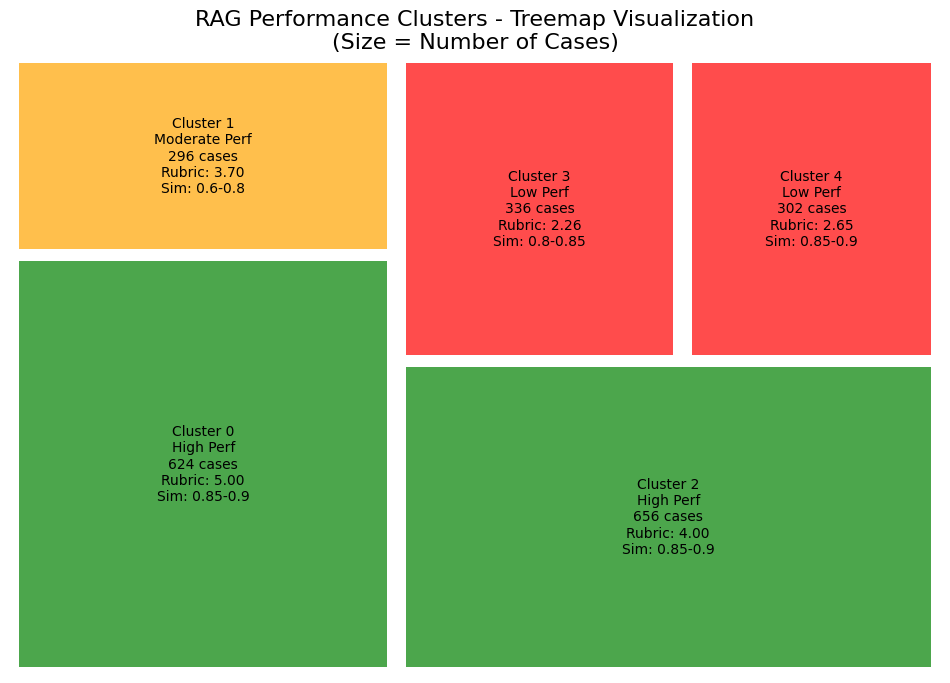

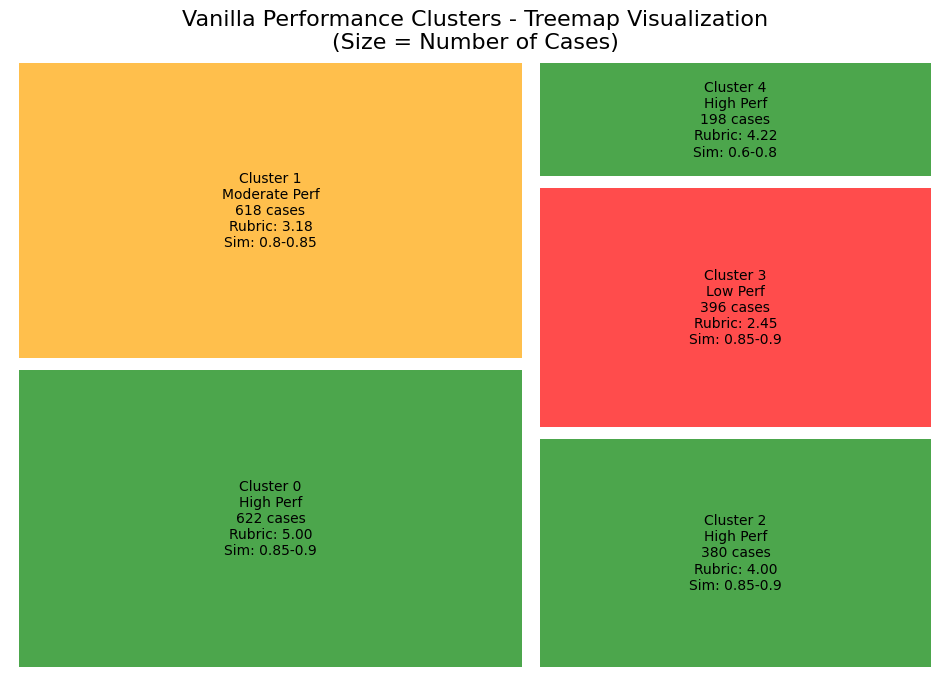

(   Cluster  Avg_Rubric  Count Most_Common_Sim_Bin
 0        0        5.00    624            0.85-0.9
 1        1        3.70    296             0.6-0.8
 2        2        4.00    656            0.85-0.9
 3        3        2.26    336            0.8-0.85
 4        4        2.65    302            0.85-0.9,
    Cluster  Avg_Rubric  Count Most_Common_Sim_Bin
 0        0        5.00    622            0.85-0.9
 1        1        3.18    618            0.8-0.85
 2        2        4.00    380            0.85-0.9
 3        3        2.45    396            0.85-0.9
 4        4        4.22    198             0.6-0.8)

In [11]:
plot_answer_similarity_distribution_facet_combined("naive_rag/results", n_clusters=5, csv_path='naive_similarity_clusters_combined.csv')